In [10]:
%matplotlib inline

In [11]:
import numpy as np

import pickle, os, math
import multiprocessing as mp
import matplotlib.pyplot as plt
from timeit import default_timer as timer

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn import svm
from sklearn import gaussian_process
from sklearn import preprocessing
from sklearn import neural_network

from scipy import stats
import gzip

In [12]:
def plot_errors(y1, y2):
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.scatter(y1, y2)
    n, bins, patches = ax2.hist(y1-y2, 50, facecolor='green', alpha=0.75)

In [13]:
class LeafNode:
    
    def __init__(self):
        self.X, self.y, self.pairs = [], [], []
        
    def append(self, X, y, pair):
        #print('id(self)', id(self), 'append X.shape', X.shape, 'y', y)
        self.X.append(X.ravel())
        self.y.append(y)
        self.pairs.append(pair)
        #print('len(self.X):', len(self.X), 'len(y):', len(self.y))
    
    def __str__(self):
        return 'leaf has ' + str(len(self.y)) + ' samples'

    def lreg(self):
        linreg = linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)
        #print('fit linear regression')
        #print('len(X):', len(self.X), 'y:', len(self.y))
        #print('X.shape:', np.array(self.X).shape, 'y.shape:', np.array(self.y).shape)
        linreg.fit(np.array(self.X), np.array(self.y))
        return linreg

In [14]:
class LinearRegETR(ExtraTreesRegressor):
    
    def __init__(self, n_estimators=10, n_jobs=1):
        super(LinearRegETR, self).__init__(n_estimators=n_estimators, n_jobs=n_jobs)
    
    def fit_leaf_model(self, X, y):

        # dictionary for each tree in the ensemble
        self.ensemble_leaf_data = [{}] * self.n_estimators
        #print('number of estimators:', self.n_estimators)
        
        # for each sample
        #print('shape of the training data X:', X.shape, 'y:', y.shape)
        k=0
        for x, y_value, pair in zip(X, y, pairs):
            k = k + 1
            # as per np request :)
            x = x.reshape(1,-1)
            
            # get a list of leafs that each point lands in
            indices = self.apply(x)[0]
        
            # put them in the dictionary
            #print('update leaf models with a new sample')
            for tnum, lind in enumerate(indices):
                lnode = self.ensemble_leaf_data[tnum].get(lind, LeafNode())
                lnode.append(x, y_value, pair)
                self.ensemble_leaf_data[tnum][lind] = lnode
                
        #print('processed samples:', k)
        #for tree in self.ensemble_leaf_data:
        #    for leafs in tree:
        #        for key, value in tree.items():
        #            print(key, ':', value)

    def leaf_model_predict(self, X):
        result = []
        for x in X:
            x = x.reshape(1, -1)
            leaf_indices = self.apply(x)[0]
            y_pred = [None]*self.n_estimators
            for tnum, lind in enumerate(leaf_indices):
                lnode = self.ensemble_leaf_data[tnum].get(lind)
                y_pred[tnum] = lnode.lreg().predict(x)
                #print('tree number:', tnum, 'predicts:', y_pred[tnum])
            result.append(np.mean(y_pred))
        return np.array(result)

    def fit(self, X, y, pairs):
        model = super(LinearRegETR, self).fit(X, y)
        self.fit_leaf_model(X, y, pairs)
        return model
    
    def predict(self, X):
        return self.leaf_model_predict(X)

In [15]:
def fit_rf(dataset_label):
    label = dataset_label
    
    # load the training and the validation data
    train = pickle.load(gzip.open('data/datasets/train_%s.pklz' % label, 'rb'))
    print(train.keys())
    X_train, y_train, pairs_train = train['X'], train['y'], train['pairs']

    # compute the mean and the std
    scaler = preprocessing.StandardScaler().fit(X_train)
    # subtract the mean and divide by the std
    X_train = scaler.transform(X_train)
    
    stats_res = stats.describe(y_train)    
    n, bins, patches = plt.hist(y_train, 50, normed=1, facecolor='green', alpha=0.75)
    plt.grid(True)
    plt.title('target data distribution: %s $\mu=%0.2g,\sigma=%0.2g$' % (label, stats_res.mean, math.sqrt(stats_res.variance)))
    plt.show()

    valid = pickle.load(gzip.open('data/datasets/valid_%s.pklz' % label, 'rb'))
    X_valid, y_valid, pairs_valid = scaler.transform(valid['X']), valid['y'], valid['pairs']

    n_estimators = 10
    models = [('LRETR', LinearRegETR()),]
    
    for tag, clf in models:
        print('model:', tag)
        start = timer()
        clf.fit(X_train, y_train, pairs_train)
        end = timer()
        print('%s, fit wall time:' % label, end-start)
    
        print('build custom leaf model')
        
        # compute the predictions the validation data
        y_pred = clf.predict(X_valid[0,:])
        print('predicted value:', y_pred)
        print('valid values:', y_valid[0], 'pair:', pairs_valid[0])
        
        mse = mean_squared_error(y_pred, y_valid[0])
        
        print("RMSE: %.2f" % math.sqrt(mse))
        
        #plot_errors(y_pred, y_valid)
        #plt.show()

        #with open(os.path.join('data', 'models', 'rf_%s.pkl' % label), 'wb') as fid:
        #    pickle.dump(clf, fid)   

dict_keys(['y', 'X', 'pairs'])


/home/kreimer/tmp/scikit-learn/sklearn/utils/validation.py:428: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


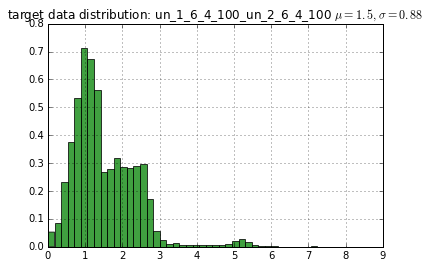

model: LRETR


TypeError: fit_leaf_model() takes 3 positional arguments but 4 were given

In [17]:
labels = []

labels.append('un_1_6_4_100_un_2_6_4_100')

for label in labels:
    fit_rf(label)

In [ ]:
def show_pair(pair):
    i1 = read_image